# Kaggle Playground 

### Problem Statement / Real World Implementations

### 1. Importing Libraries

In [1]:
# Core Data Science Libraries
import numpy as np
import pandas as pd
import warnings

# Visualization Libraries
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Scikit-learn for Preprocessing and Modeling
from sklearn.model_selection import KFold, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Machine Learning Models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Hyperparameter Tuning
import optuna

# Notebook settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

### 2. Loading Dataset

In [2]:
# Define file paths
TRAIN_PATH = "/kaggle/input/playground-series-s5e11/train.csv"
TEST_PATH = "/kaggle/input/playground-series-s5e11/test.csv"
SUBMISSION_PATH = "/kaggle/input/playground-series-s5e11/sample_submission.csv"

# Load the datasets into pandas DataFrames
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
submission_df = pd.read_csv(SUBMISSION_PATH)

### Refining the Original dataset

In [3]:
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (593994, 13)
Test shape: (254569, 12)


In [4]:
df=train_df
df.head(5)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0


In [5]:
print(df["gender"].unique())
print(df["marital_status"].unique())
print(df["education_level"].unique())
print(df["employment_status"].unique())
print(df["loan_purpose"].unique())
print(df["grade_subgrade"].unique())

['Female' 'Male' 'Other']
['Single' 'Married' 'Divorced' 'Widowed']
['High School' "Master's" "Bachelor's" 'PhD' 'Other']
['Self-employed' 'Employed' 'Unemployed' 'Retired' 'Student']
['Other' 'Debt consolidation' 'Home' 'Education' 'Vacation' 'Car'
 'Medical' 'Business']
['C3' 'D3' 'C5' 'F1' 'D1' 'D5' 'C2' 'C1' 'F5' 'D4' 'C4' 'D2' 'E5' 'B1'
 'B2' 'F4' 'A4' 'E1' 'F2' 'B4' 'E4' 'B3' 'E3' 'B5' 'E2' 'F3' 'A5' 'A3'
 'A1' 'A2']


In [6]:
df.isna().sum()

id                      0
annual_income           0
debt_to_income_ratio    0
credit_score            0
loan_amount             0
interest_rate           0
gender                  0
marital_status          0
education_level         0
employment_status       0
loan_purpose            0
grade_subgrade          0
loan_paid_back          0
dtype: int64

In [7]:
df.head(10)

,id,annual_income,debt_to_income_ratio,credit_score,loan_amount,interest_rate,gender,marital_status,education_level,employment_status,loan_purpose,grade_subgrade,loan_paid_back
0,0,29367.99,0.084,736,2528.42,13.67,Female,Single,High School,Self-employed,Other,C3,1.0
1,1,22108.02,0.166,636,4593.10,12.92,Male,Married,Master's,Employed,Debt consolidation,D3,0.0
2,2,49566.20,0.097,694,17005.15,9.76,Male,Single,High School,Employed,Debt consolidation,C5,1.0
3,3,46858.25,0.065,533,4682.48,16.10,Female,Single,High School,Employed,Debt consolidation,F1,1.0
4,4,25496.70,0.053,665,12184.43,10.21,Male,Married,High School,Employed,Other,D1,1.0
5,5,44940.30,0.058,653,12159.92,12.24,Male,Single,Bachelor's,Employed,Other,D1,1.0
6,6,61574.16,0.042,696,16907.71,13.52,Other,Single,High School,Self-employed,Debt consolidation,C5,1.0
7,7,45953.31,0.100,654,10111.62,12.82,Female,Married,High School,Employed,Home,D1,1.0
8,8,30592.29,0.132,713,7522.36,9.48,Male,Married,Bachelor's,Employed,Education,C5,1.0
9,9,17342.45,0.121,548,9653.48,16.04,Female,Married,Bachelor's,Self-employed,Vacation,F1,1.0


### 4. EDA

In [8]:
# Select only numeric columns for correlation matrix
numerical_cols = train_df.select_dtypes(include=np.number).columns.tolist()
numerical_cols.remove('id')
numerical_cols.remove('loan_paid_back')

numeric_df = train_df[numerical_cols + ['loan_paid_back']]
corr_matrix = numeric_df.corr()

# Create the interactive heatmap
fig = go.Figure(data=go.Heatmap(
                   z=corr_matrix.values,
                   x=corr_matrix.columns,
                   y=corr_matrix.columns,
                   colorscale='RdBu_r',
                   zmin=-1, zmax=1,
                   text=corr_matrix.round(2).values,
                   texttemplate="%{text}",
                   hoverongaps=False))

fig.update_layout(
    title='Correlation Heatmap of Numerical Features',
    width=800, height=800
)
fig.show()

### 3. Normalization of data

In [9]:
# Save the test IDs for your submission file
test_ids = test_df['id']

# Drop the 'id' column from both, as it's not a feature
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

In [10]:
def create_financial_features(df):
    """
    Creates new financial features from the existing columns.
    """
    # Create monthly_income
    df['monthly_income'] = df['annual_income'] / 12
    
    # Create total_monthly_debt
    df['total_monthly_debt'] = df['debt_to_income_ratio'] * df['monthly_income']
    
    # Create available_income (disposable income)
    df['available_income'] = df['monthly_income'] - df['total_monthly_debt']
    
    # Create loan_to_income_ratio
    df['loan_to_income_ratio'] = df['loan_amount'] / df['annual_income']
    
    # Create loan_to_available_income
    # We will replace inf/-inf with NaN later
    df['loan_to_available_income'] = df['loan_amount'] / df['available_income']
    
    return df

# Assuming 'train_df' and 'test_df' are already loaded

print("Applying features to train_df...")
train_df = create_financial_features(train_df)

print("Applying features to test_df...")
test_df = create_financial_features(test_df)

Applying features to train_df...
Applying features to test_df...


In [11]:
import pandas as pd
import numpy as np

def process_risk_features(df):
    """
    Applies ordinal mapping and binning to risk features.
    (Corrected version)
    """
    
    # 1. Map grade_subgrade
    # This map is correct and complete.
    grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
    subgrades = ['1', '2', '3', '4', '5']
    grade_map = {}
    i = 0
    for g in grades:
        for s in subgrades:
            grade_map[g + s] = i
            i += 1
            
    df['grade_subgrade_ordinal'] = df['grade_subgrade'].map(grade_map)

    # 2. Map education_level (FIXED)
    # This map now includes 'PhD' and 'Other'
    # We place them in a logical ordinal scale.
    education_map = {
        'Other': 0,         # Treat 'Other' as the baseline
        'High School': 1,
        'Bachelor\'s': 2,
        'Master\'s': 3,
        'PhD': 4            # 'PhD' is the highest
    }
    df['education_level_ordinal'] = df['education_level'].map(education_map)

    # 3. Bin credit_score
    # This logic is correct.
    score_bins = [300, 579, 669, 739, 799, 850]
    score_labels = ['Poor', 'Fair', 'Good', 'Very Good', 'Excellent']
    
    df['credit_score_bin'] = pd.cut(df['credit_score'], 
                                   bins=score_bins, 
                                   labels=score_labels, 
                                   include_lowest=True)
    
    # 4. Drop original columns
    cols_to_drop = ['grade_subgrade', 'education_level', 'credit_score']
    df = df.drop(columns=cols_to_drop)
    
    return df

In [12]:
cols_to_drop = ['annual_income', 'debt_to_income_ratio']

# --- Clean Training Data ---
train_df = train_df.drop(columns=cols_to_drop)
train_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# --- Clean Test Data ---
test_df = test_df.drop(columns=cols_to_drop)
test_df.replace([np.inf, -np.inf], np.nan, inplace=True)


print("Feature creation complete. Redundant columns dropped.")
print("\n--- train_df columns ---")
print(list(train_df.columns))

print("\n--- test_df columns ---")
print(list(test_df.columns))

Feature creation complete. Redundant columns dropped.

--- train_df columns ---
['credit_score', 'loan_amount', 'interest_rate', 'gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'loan_paid_back', 'monthly_income', 'total_monthly_debt', 'available_income', 'loan_to_income_ratio', 'loan_to_available_income']

--- test_df columns ---
['credit_score', 'loan_amount', 'interest_rate', 'gender', 'marital_status', 'education_level', 'employment_status', 'loan_purpose', 'grade_subgrade', 'monthly_income', 'total_monthly_debt', 'available_income', 'loan_to_income_ratio', 'loan_to_available_income']


In [13]:
# --- Apply to train_df ---
print("Processing train_df...")
train_df = process_risk_features(train_df)

# --- Apply to test_df ---
print("Processing test_df...")
test_df = process_risk_features(test_df)

print("\nFeature creation complete. Original columns dropped.")

# --- Show New Columns ---
print("\n--- train_df columns ---")
print(list(train_df.columns))

print("\n--- test_df columns ---")
print(list(test_df.columns))

# --- Check the new binned values ---
print("\n--- Value counts for new 'credit_score_bin' (from train_df) ---")
print(train_df['credit_score_bin'].value_counts())

Processing train_df...
Processing test_df...

Feature creation complete. Original columns dropped.

--- train_df columns ---
['loan_amount', 'interest_rate', 'gender', 'marital_status', 'employment_status', 'loan_purpose', 'loan_paid_back', 'monthly_income', 'total_monthly_debt', 'available_income', 'loan_to_income_ratio', 'loan_to_available_income', 'grade_subgrade_ordinal', 'education_level_ordinal', 'credit_score_bin']

--- test_df columns ---
['loan_amount', 'interest_rate', 'gender', 'marital_status', 'employment_status', 'loan_purpose', 'monthly_income', 'total_monthly_debt', 'available_income', 'loan_to_income_ratio', 'loan_to_available_income', 'grade_subgrade_ordinal', 'education_level_ordinal', 'credit_score_bin']

--- Value counts for new 'credit_score_bin' (from train_df) ---
credit_score_bin
Good         275585
Fair         209954
Very Good     71337
Poor          27266
Excellent      9852
Name: count, dtype: int64


In [14]:
from sklearn.preprocessing import OneHotEncoder

categorical_cols = [
    'gender', 
    'marital_status', 
    'employment_status', 
    'loan_purpose', 
    'credit_score_bin'
]

ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype='int')

print("Fitting One-Hot Encoder on train_df...")
# Note: We must convert .astype(str) because 'credit_score_bin' is a category
ohe.fit(train_df[categorical_cols].astype(str))

# 3. TRANSFORM both train_df and test_df
print("Transforming train_df...")
# --- Process train_df ---
# Get the new encoded columns
train_encoded = ohe.transform(train_df[categorical_cols].astype(str))
# Get the new column names
encoded_feature_names = ohe.get_feature_names_out(categorical_cols)
# Create a new DataFrame with the encoded features
train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_feature_names, index=train_df.index)
# Drop the original text columns
train_processed = train_df.drop(columns=categorical_cols)
# Add the new numeric columns
train_processed = pd.concat([train_processed, train_encoded_df], axis=1)


print("Transforming test_df...")
# --- Process test_df ---
# Use the SAME fitted encoder to transform test_df
test_encoded = ohe.transform(test_df[categorical_cols].astype(str))
# Create a new DataFrame with the encoded features
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_feature_names, index=test_df.index)
# Drop the original text columns
test_processed = test_df.drop(columns=categorical_cols)
# Add the new numeric columns
test_processed = pd.concat([test_processed, test_encoded_df], axis=1)


print("\n--- Encoding Complete ---")
print("train_processed is ready for training.")
print("test_processed is ready for prediction.")

Fitting One-Hot Encoder on train_df...
Transforming train_df...
Transforming test_df...

--- Encoding Complete ---
train_processed is ready for training.
test_processed is ready for prediction.


In [15]:
train_df.head(5)

,loan_amount,interest_rate,gender,marital_status,employment_status,loan_purpose,loan_paid_back,monthly_income,total_monthly_debt,available_income,loan_to_income_ratio,loan_to_available_income,grade_subgrade_ordinal,education_level_ordinal,credit_score_bin
0,2528.42,13.67,Female,Single,Self-employed,Other,1.0,2447.332500,205.575930,2241.756570,0.086094,1.127874,12,1,Good
1,4593.10,12.92,Male,Married,Employed,Debt consolidation,0.0,1842.335000,305.827610,1536.507390,0.207757,2.989312,17,3,Fair
2,17005.15,9.76,Male,Single,Employed,Debt consolidation,1.0,4130.516667,400.660117,3729.856550,0.343080,4.559197,14,1,Good
3,4682.48,16.10,Female,Single,Employed,Debt consolidation,1.0,3904.854167,253.815521,3651.038646,0.099929,1.282506,25,1,Poor
4,12184.43,10.21,Male,Married,Employed,Other,1.0,2124.725000,112.610425,2012.114575,0.477883,6.055535,15,1,Fair


Summary Statistics:



,loan_amount,interest_rate,monthly_income,total_monthly_debt,available_income,loan_to_income_ratio,loan_to_available_income,grade_subgrade_ordinal,education_level_ordinal,gender_Female,gender_Male,gender_Other,marital_status_Divorced,marital_status_Married,marital_status_Single,marital_status_Widowed,employment_status_Employed,employment_status_Retired,employment_status_Self-employed,employment_status_Student,employment_status_Unemployed,loan_purpose_Business,loan_purpose_Car,loan_purpose_Debt consolidation,loan_purpose_Education,loan_purpose_Home,loan_purpose_Medical,loan_purpose_Other,loan_purpose_Vacation,credit_score_bin_Excellent,credit_score_bin_Fair,credit_score_bin_Good,credit_score_bin_Poor,credit_score_bin_Very Good
count,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000,593994.000000
mean,15020.297629,12.356345,4017.683581,485.002319,3532.681262,0.427574,5.875664,13.967705,1.794939,0.515451,0.478273,0.006276,0.035879,0.466737,0.486273,0.011111,0.758669,0.027699,0.088351,0.020086,0.105195,0.059433,0.097826,0.546630,0.061686,0.074273,0.038394,0.107533,0.014224,0.016586,0.353461,0.463952,0.045903,0.120097
std,6926.530568,2.008959,2225.995173,415.297292,1979.316733,0.366041,5.081131,5.115538,0.823183,0.499762,0.499528,0.078973,0.185989,0.498893,0.499812,0.104823,0.427891,0.164109,0.283805,0.140295,0.306804,0.236434,0.297079,0.497821,0.240584,0.262216,0.192146,0.309790,0.118413,0.127714,0.478045,0.498699,0.209275,0.325075
min,500.090000,3.200000,500.202500,7.014620,274.692110,0.002491,0.032883,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,10279.620000,10.990000,2327.866667,216.130683,2037.879680,0.194734,2.653587,11.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15000.220000,12.370000,3879.806667,367.691262,3386.199475,0.322538,4.406622,13.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18858.580000,13.680000,5081.776667,615.139751,4450.237361,0.536990,7.385818,17.000000,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
max,48959.950000,20.990000,32781.811667,11151.413863,31477.877736,5.461143,94.091476,29.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Feature Ranges:

loan_amount                        48459.860000
monthly_income                     32281.609167
available_income                   31203.185626
total_monthly_debt                 11144.399243
loan_to_available_income              94.058593
grade_subgrade_ordinal                29.000000
interest_rate                         17.790000
loan_to_income_ratio                   5.458652
education_level_ordinal                4.000000
gender_Female                          1.000000
gender_Male                            1.000000
gender_Other                           1.000000
marital_status_Divorced                1.000000
marital_status_Married                 1.000000
marital_status_Single                  1.000000
marital_status_Widowed                 1.000000
employment_status_Employed             1.000000
employment_status_Retired              1.000000
employment_status_Self-employed        1.000000
employment_status_Student              1.000000
employment_status_Unem

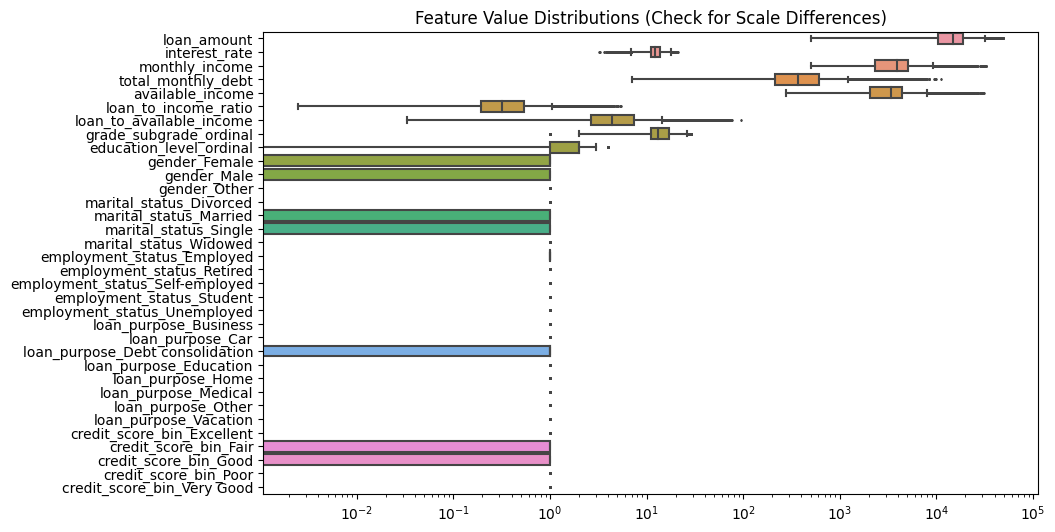


Features with significantly higher ranges: ['loan_amount', 'monthly_income', 'total_monthly_debt', 'available_income']

✅ Feature scaling is likely necessary (large scale differences detected).


In [16]:
# Exclude target column if present
features = train_processed.drop(columns=['loan_paid_back'], errors='ignore')

# 1. Check summary statistics
print("Summary Statistics:\n")
display(features.describe())

# 2. Check for large differences in scale
range_df = features.max() - features.min()
print("\nFeature Ranges:\n")
print(range_df.sort_values(ascending=False))

# 3. Visualize distribution of feature scales
plt.figure(figsize=(10, 6))
sns.boxplot(data=features, orient='h', fliersize=1)
plt.title("Feature Value Distributions (Check for Scale Differences)")
plt.xscale('log')
plt.show()

# 4. Correlation check
corr_matrix = features.corr()
high_range_features = range_df[range_df > range_df.mean()].index.tolist()
print(f"\nFeatures with significantly higher ranges: {high_range_features}")

# 5. Quick rule-based decision
if range_df.max() / range_df.min() > 10:
    print("\n✅ Feature scaling is likely necessary (large scale differences detected).")
else:
    print("\n❌ Feature scaling might not be strictly necessary (features on similar scales).")

### Train test split

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
import numpy as np

# Use encoded data for model training
X = train_processed.drop("loan_paid_back", axis=1)
y = train_processed["loan_paid_back"]

# Ensure all columns are numeric
X = X.select_dtypes(include=[np.number])

# Train–test split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Choose scaling method
selected_method = 'Standard Scaling'

# Apply the best scaling method
if selected_method == 'Min-Max Scaling':
    scaler = MinMaxScaler()
elif selected_method == 'Standard Scaling':
    scaler = StandardScaler()
elif selected_method == 'Robust Scaling':
    scaler = RobustScaler()
elif selected_method == 'Power Transformation':
    scaler = PowerTransformer(method='yeo-johnson')
else:
    scaler = None 

# Perform scaling
if scaler is not None:
    # Fit on training data
    X_train_scaled = scaler.fit_transform(X_train)
    # Only transform validation data
    X_val_scaled = scaler.transform(X_val) 
else:
    X_train_scaled = X_train
    X_val_scaled = X_val
    
print("Scaling for tuning complete.")

Scaling for tuning complete.


In [18]:
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score # <-- Correct metrics
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# ✅ Enable GPU for both XGBoost and LightGBM

# --- Hyperparameter tuning for XGBClassifier ---
def objective_xgb(trial):
    param = {
        'tree_method': 'gpu_hist',  
        'predictor': 'gpu_predictor', 
        'gpu_id': 0,
        'objective': 'binary:logistic', # <-- CORRECTED: Set objective for classification
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3, 0.5, 0.7, 0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.5, 0.6, 0.7, 0.8, 1.0]),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'random_state': 42
    }

    model = XGBClassifier(**param, verbosity=0) # <-- CORRECTED: Classifier
    model.fit(X_train_scaled, y_train)
    y_pred_proba = model.predict_proba(X_val_scaled)[:, 1] # <-- Get probabilities
    ll = log_loss(y_val, y_pred_proba) # <-- CORRECTED: Use log_loss
    return ll


# --- Hyperparameter tuning for LGBMClassifier ---
def objective_lgbm(trial):
    param = {
        'device': 'gpu', 
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'boosting_type': 'gbdt',
        'objective': 'binary', # <-- CORRECTED: Set objective for classification
        'metric': 'binary_logloss', # <-- CORRECTED: Set metric
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-5, 1.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-5, 1.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000, step=100),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'random_state': 42,
        'verbosity': -1
    }

    model = LGBMClassifier(**param) # <-- CORRECTED: Classifier
    model.fit(X_train_scaled, y_train)
    y_pred_proba = model.predict_proba(X_val_scaled)[:, 1] # <-- Get probabilities
    ll = log_loss(y_val, y_pred_proba) # <-- CORRECTED: Use log_loss
    return ll

# --- Run GPU-accelerated Optuna optimization ---
print("🚀 Tuning XGBClassifier (GPU)...")
study_xgb = optuna.create_study(direction='minimize') # Minimize log_loss
study_xgb.optimize(objective_xgb, n_trials=50, timeout=600)
best_params_xgb = study_xgb.best_params
print(f"✅ Best XGBClassifier parameters: {best_params_xgb}")

print("\n🚀 Tuning LGBMClassifier (GPU)...")
study_lgbm = optuna.create_study(direction='minimize') # Minimize log_loss
study_lgbm.optimize(objective_lgbm, n_trials=50, timeout=600)
best_params_lgbm = study_lgbm.best_params
print(f"✅ Best LGBMClassifier parameters: {best_params_lgbm}")


# --- Initialize models with tuned GPU parameters ---
xgb_model = XGBClassifier(**best_params_xgb, tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0, objective='binary:logistic')
lgbm_model = LGBMClassifier(**best_params_lgbm, device='gpu', objective='binary')

models = [
    ("XGBClassifier (GPU)", xgb_model),
    ("LGBMClassifier (GPU)", lgbm_model)
]

print("\n⚡ Evaluating Tuned Models on GPU...\n")
logloss_scores = []
model_names = []

for name, model in models:
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_val_scaled)
    y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    
    # --- CORRECTED Metrics ---
    ll = log_loss(y_val, y_pred_proba)
    acc = accuracy_score(y_val, y_pred)
    auc = roc_auc_score(y_val, y_pred_proba)

    logloss_scores.append(ll)
    model_names.append(name)

    print(f"{name:<30} | LogLoss: {ll:.5f} | Accuracy: {acc:.5f} | ROC AUC: {auc:.5f}")

[I 2025-11-03 07:15:12,165] A new study created in memory with name: no-name-8afcf609-3efc-4631-a3bc-8b843a3cd5f2


🚀 Tuning XGBClassifier (GPU)...


[I 2025-11-03 07:15:17,864] Trial 0 finished with value: 0.2645231073170942 and parameters: {'lambda': 0.0361936500047033, 'alpha': 0.007568899354734025, 'colsample_bytree': 1.0, 'subsample': 0.6, 'learning_rate': 0.009507472541685866, 'n_estimators': 300, 'max_depth': 11, 'min_child_weight': 121}. Best is trial 0 with value: 0.2645231073170942.
[I 2025-11-03 07:15:26,473] Trial 1 finished with value: 0.2573499981158369 and parameters: {'lambda': 0.09118575472550126, 'alpha': 0.006382495033513585, 'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.020666723707219982, 'n_estimators': 900, 'max_depth': 8, 'min_child_weight': 58}. Best is trial 1 with value: 0.2573499981158369.
[I 2025-11-03 07:15:32,359] Trial 2 finished with value: 0.2592545912919665 and parameters: {'lambda': 0.012995029534803772, 'alpha': 0.6651609154168596, 'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.013830255474092062, 'n_estimators': 1000, 'max_depth': 4, 'min_child_weight': 202}. Best 

✅ Best XGBClassifier parameters: {'lambda': 5.886232957483388, 'alpha': 0.025940388011077873, 'colsample_bytree': 0.3, 'subsample': 0.8, 'learning_rate': 0.026569438393859245, 'n_estimators': 900, 'max_depth': 8, 'min_child_weight': 46}

🚀 Tuning LGBMClassifier (GPU)...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
[I 2025-11-03 07:20:57,851] Trial 0 finished with value: 0.2596210099951706 and parameters: {'lambda_l1': 0.002716602839774946, 'lambda_l2': 0.0003836313790088529, 'num_leaves': 135, 'feature_fraction': 0.6543029519801753, 'bagging_fraction': 0.5318032723554944, 'bagging_freq': 4, 'min_child_samples': 56, 

✅ Best LGBMClassifier parameters: {'lambda_l1': 0.0006676400275768641, 'lambda_l2': 6.882280051749269e-05, 'num_leaves': 155, 'feature_fraction': 0.5063358344178233, 'bagging_fraction': 0.9060032142363916, 'bagging_freq': 3, 'min_child_samples': 43, 'learning_rate': 0.026077518808694123, 'n_estimators': 700, 'max_depth': 8}

⚡ Evaluating Tuned Models on GPU...

XGBClassifier (GPU)            | LogLoss: 0.25703 | Accuracy: 0.90212 | ROC AUC: 0.91283
LGBMClassifier (GPU)           | LogLoss: 0.25734 | Accuracy: 0.90231 | ROC AUC: 0.91260


In [19]:
# Select best model
best_idx = np.argmin(logloss_scores) # <-- Select based on lowest log_loss
best_model_name = model_names[best_idx]
best_model = models[best_idx][1]
print(f"\n✅ Best Model Based on LogLoss: {best_model_name}")

# Evaluate final model
y_pred = best_model.predict(X_val_scaled)
y_pred_proba = best_model.predict_proba(X_val_scaled)[:, 1]

ll_final = log_loss(y_val, y_pred_proba)
acc_final = accuracy_score(y_val, y_pred)
auc_final = roc_auc_score(y_val, y_pred_proba)

print("\n✅ Final Model Evaluation (on validation set):")
print(f"LogLoss    : {ll_final:.5f}")
print(f"Accuracy   : {acc_final:.5f}")
print(f"ROC AUC Score: {auc_final:.5f}")


✅ Best Model Based on LogLoss: XGBClassifier (GPU)

✅ Final Model Evaluation (on validation set):
LogLoss    : 0.25703
Accuracy   : 0.90212
ROC AUC Score: 0.91283


### Selecting best model and Generating Submission

In [20]:
print("\n🚀 Retraining the best model on full training data...")

# Prepare full training features and target
X_full = train_processed.drop(columns=['loan_paid_back'], errors='ignore')
y_full = train_processed['loan_paid_back']

# Ensure all columns are numeric
X_full = X_full.select_dtypes(include=[np.number])

# Scale full data using the same scaler
if scaler is not None:
    # We must re-fit the scaler on the FULL training data
    X_full_scaled = scaler.fit_transform(X_full) 
else:
    X_full_scaled = X_full

# Retrain best model on the full scaled dataset
best_model.fit(X_full_scaled, y_full)

print(f"✅ Model retrained successfully: {best_model_name} ({best_model.__class__.__name__})\n")


🚀 Retraining the best model on full training data...
✅ Model retrained successfully: XGBClassifier (GPU) (XGBClassifier)



### Submission creation

In [21]:
X_submission = test_processed.select_dtypes(include=[np.number])

# Ensure column order matches the training data
X_submission = X_submission[X_full.columns] 

# Scale using the scaler that was fit on X_full
if scaler is not None:
    X_submission_scaled = scaler.transform(X_submission)
else:
    X_submission_scaled = X_submission

In [22]:
print("🔮 Generating predictions using the best model...")
# Predict probabilities for the submission
submission_preds = best_model.predict_proba(X_submission_scaled)[:, 1]

# Optional: clip predictions to valid range [0, 1]
submission_preds = np.clip(submission_preds, 0, 1)

🔮 Generating predictions using the best model...


In [23]:
submission = pd.DataFrame({
    'id': test_ids,
    'loan_paid_back': submission_preds
})
submission.to_csv('submission.csv', index=False)
print("\n✅ Submission file 'submission.csv' generated successfully!")
display(submission.head())


✅ Submission file 'submission.csv' generated successfully!


,id,loan_paid_back
0,593994,0.944431
1,593995,0.955119
2,593996,0.431062
3,593997,0.962783
4,593998,0.978027


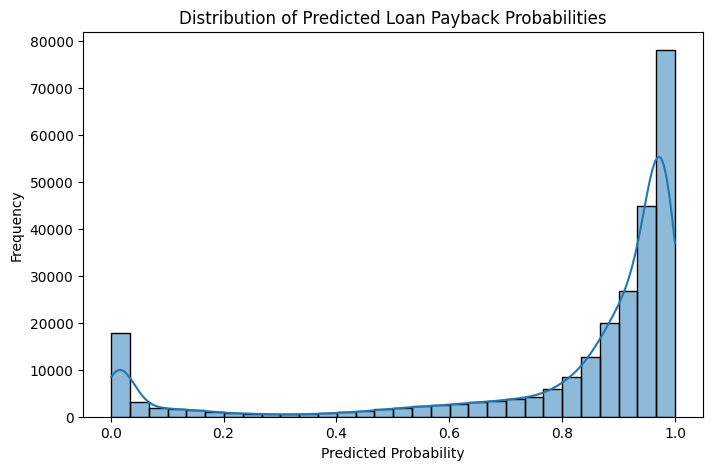

In [24]:
plt.figure(figsize=(8, 5))
sns.histplot(submission['loan_paid_back'], bins=30, kde=True)
plt.title('Distribution of Predicted Loan Payback Probabilities')
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.show()